# # Homework: Week 3
Orhan Soyuhos

In [72]:
import json
import numpy as np
import math
from sklearn.metrics import confusion_matrix, accuracy_score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## -> Dataset 

In [7]:
# Python: Reading JSON

#open file
f = open('hw3.json')
example_data = json.load(f)
f.close()

events_data = example_data['events']
neurons_data = example_data['neurons']

In [8]:
events_data.keys(), len(neurons_data.keys()), neurons_data.keys()

(dict_keys(['event_1', 'event_2', 'event_3', 'event_4']),
 29,
 dict_keys(['sig001a', 'sig002a', 'sig002b', 'sig002c', 'sig003a', 'sig003b', 'sig004a', 'sig004b', 'sig005a', 'sig005b', 'sig006a', 'sig006b', 'sig006c', 'sig007a', 'sig007b', 'sig007c', 'sig008a', 'sig008b', 'sig008c', 'sig009a', 'sig010a', 'sig010b', 'sig011a', 'sig012a', 'sig013a', 'sig014a', 'sig015a', 'sig016a', 'sig016b']))

## -> Store the data  

In [9]:
class neuron:
    def __init__(self, name, neurons_data, events_data):
        self.name = name
        self.neuron_data = np.array(neurons_data[name])
        self.events_data = np.array(events_data)
        
    def relative_spike(self):
        events_data_typeList = self.events_data.tolist()
        neuron_data = self.neuron_data
        relative_spikes = dict()
        
        for key, value in events_data_typeList.items():
            tmp_data = list()
            for event_time in value:
                tmp_data.append(list(neuron_data - event_time))
                relative_spikes[key] = tmp_data
                
        return relative_spikes
    
    def relative_response_matrix(self, bin_size):
        relative_spikes = self.relative_spike()
        rrm = dict() 
        
        for event_key, relative_spikes in relative_spikes.items():            
            rrm[event_key] = []
            for relative_spike in relative_spikes:
                response_start = 0
                response_end = 0.2
                response_window = list(np.arange(response_start, response_end, bin_size))
                total_bins = len(response_window)
                binned_spikes = np.histogram(relative_spike, total_bins, range = (response_start, response_end))[0]
                rrm[event_key].append(binned_spikes)

        return rrm
    
    def PSTH_template(self, bin_size):
        rrm = self.relative_response_matrix(bin_size)
        PSTH_template = dict()
        
        for event_key, rrm_value in rrm.items():   
            PSTH_template[event_key] = rrm_value

        return PSTH_template

In [10]:
class events:
    def __init__(self, neurons_data, events_data):
        self.neurons_data = neurons_data
        self.events_data = events_data
        
    def PSTH_templates(self, bin_size):        
        PSTH_templates = dict()    
        events_data = self.events_data
        neurons_data = self.neurons_data
        
        for event_key, event_value in events_data.items():
            PSTH_template = []
            for neuron_key, neuron_value in neurons_data.items():
                neuron_class = neuron(neuron_key, neurons_data, events_data)
                tmp_template = neuron_class.PSTH_template(bin_size)
                PSTH_template.append(tmp_template[event_key])
            PSTH_templates[event_key] = np.array(PSTH_template)
            
        return PSTH_templates

In [11]:
all_events = events(neurons_data, events_data)

#select: 0.005, 0.05, 0.2
PSTH_templates_0005 = all_events.PSTH_templates(0.005)
PSTH_templates_005 = all_events.PSTH_templates(0.05)
PSTH_templates_02 = all_events.PSTH_templates(0.2)

## -> Part 1: Creating the Classifier

In [44]:
PSTH_templates_02['event_1'].shape

(29, 71, 1)

In [45]:
def X_events(PSTH_templates):

    event_1_T = np.transpose(PSTH_templates['event_1'], (1,0,2))
    event_2_T = np.transpose(PSTH_templates['event_2'], (1,0,2))
    event_3_T = np.transpose(PSTH_templates['event_3'], (1,0,2))
    event_4_T = np.transpose(PSTH_templates['event_4'], (1,0,2))

    X = dict()
    X['event_1_T'] = event_1_T
    X['event_2_T'] = event_2_T
    X['event_3_T'] = event_3_T
    X['event_4_T'] = event_4_T
    
    return X

In [46]:
X_0005 = X_events(PSTH_templates_0005)
X_005 = X_events(PSTH_templates_005)
X_02 = X_events(PSTH_templates_02)

In [47]:
class classifier:
    def __init__(self, X):
        self.event_1 = X['event_1_T'] 
        self.event_2 = X['event_2_T'] 
        self.event_3 = X['event_3_T']
        self.event_4 = X['event_4_T']
        self.temp_1 = np.mean(self.event_1, 0)
        self.temp_2 = np.mean(self.event_2, 0)
        self.temp_3 = np.mean(self.event_3, 0)
        self.temp_4 = np.mean(self.event_4, 0)

    def leave_one_out(self): 
        y_hats = []
        for i in range(len(self.event_1)):    
            left_out = self.event_1[i]
            train_1 = np.delete(self.event_1, i, axis = 0)
            temp_1 = np.mean(train_1, 0)
            dist_1 = self.measure_dist(left_out, temp_1)
            dist_2 = self.measure_dist(left_out, self.temp_2)
            dist_3 = self.measure_dist(left_out, self.temp_3)
            dist_4 = self.measure_dist(left_out, self.temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))

        for i in range(len(self.event_2)):    
            left_out = self.event_2[i]
            train_2 = np.delete(self.event_2, i, axis = 0)
            temp_2 = np.mean(train_2, 0)
            dist_1 = self.measure_dist(left_out, self.temp_1)
            dist_2 = self.measure_dist(left_out, temp_2)
            dist_3 = self.measure_dist(left_out, self.temp_3)
            dist_4 = self.measure_dist(left_out, self.temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))
            
        for i in range(len(self.event_3)):    
            left_out = self.event_3[i]
            train_3 = np.delete(self.event_3, i, axis = 0)
            temp_3 = np.mean(train_3, 0)
            dist_1 = self.measure_dist(left_out, self.temp_1)
            dist_2 = self.measure_dist(left_out, self.temp_2)
            dist_3 = self.measure_dist(left_out, temp_3)
            dist_4 = self.measure_dist(left_out, self.temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))
            
        for i in range(len(self.event_4)):    
            left_out = self.event_4[i]
            train_4 = np.delete(self.event_4, i, axis = 0)
            temp_4 = np.mean(train_4, 0)
            dist_1 = self.measure_dist(left_out, self.temp_1)
            dist_2 = self.measure_dist(left_out, self.temp_2)
            dist_3 = self.measure_dist(left_out, self.temp_3)
            dist_4 = self.measure_dist(left_out, temp_4)
            distances = np.append([], [dist_1, dist_2, dist_3, dist_4])
            min_idx = distances.tolist().index(min(distances))
            y_hats.append(self.predict(min_idx))
                
        return y_hats

    def predict(self, min_idx):        
        if min_idx == 0:
            y_hat = 1
        elif min_idx == 1:
            y_hat = 2
        elif min_idx == 2:
            y_hat = 3
        elif min_idx == 3:
            y_hat = 4
        return y_hat
    
    def measure_dist(self, x, y):
        distance = np.linalg.norm(np.array(x) - np.array(y))
        return distance

In [49]:
labels = [1]*X_02['event_1_T'].shape[0] + [2]*X_02['event_2_T'].shape[0] + [3]*X_02['event_3_T'].shape[0] + [4]*X_02['event_4_T'].shape[0]

In [50]:
y_hats_0005 = classifier(X_0005).leave_one_out()
y_hats_005 = classifier(X_005).leave_one_out()
y_hats_02 = classifier(X_02).leave_one_out()

## -> Part 2: Confusion Matrix and Accuracy

In [51]:
result_confusion_0005 = confusion_matrix(labels, y_hats_0005)
result_confusion_005 = confusion_matrix(labels, y_hats_005)
result_confusion_02 = confusion_matrix(labels, y_hats_02)

In [52]:
accuracy_0005 = accuracy_score(labels, y_hats_0005)
accuracy_005 = accuracy_score(labels, y_hats_005)
accuracy_02 = accuracy_score(labels, y_hats_02)
accuracy_0005, accuracy_005, accuracy_02

(0.7366666666666667, 0.79, 0.6766666666666666)

## -> Part 3: Mutual Information

In [53]:
def mutual_info(result_confusion):

    row_entropy = []
    total = sum(sum(result_confusion))
    for i in range(len(result_confusion)):
        row = 0
        for j in range(len(result_confusion)):
            row += result_confusion[i][j]
        row_entropy.append(row)


    col_entropy = []
    ele_e = 0
    for i in range(len(result_confusion)):
        col = 0
        for j in range(len(result_confusion)):
            e = result_confusion[j][i]/total
            if e != 0:
                ele_e += e * math.log(e, 2)
            col += result_confusion[j][i]
        col_entropy.append(col)


    row_e = 0
    col_e = 0
    for i in range(len(col_entropy)):
        r = row_entropy[i]/total
        c = col_entropy[i]/total
        col_e += c * math.log(c, 2)
        row_e += r * math.log(r, 2)

    row_e = row_e * -1
    col_e = col_e * -1
    ele_e = ele_e * -1

    mutual_info = col_e + row_e - ele_e

    return mutual_info

In [54]:
mutual_info_0005 = mutual_info(result_confusion_0005)
mutual_info_005 = mutual_info(result_confusion_005)
mutual_info_02 = mutual_info(result_confusion_02)
mutual_info_0005, mutual_info_005, mutual_info_02

(0.8795225485801028, 1.0484113707244425, 0.6699668354280353)

## # Save to JSON file

In [55]:
hw3_results = dict()

hw3_results['bin_200ms'] = dict()
hw3_results['bin_200ms']['performance'] = accuracy_02
hw3_results['bin_200ms']['mutual_info'] = mutual_info_02
hw3_results['bin_200ms']['confusion_matrix'] = result_confusion_02.tolist()

hw3_results['bin_50ms'] = dict()
hw3_results['bin_50ms']['performance'] = accuracy_005
hw3_results['bin_50ms']['mutual_info'] = mutual_info_005
hw3_results['bin_50ms']['confusion_matrix'] = result_confusion_005.tolist()

hw3_results['bin_5ms'] = dict()
hw3_results['bin_5ms']['performance'] = accuracy_0005
hw3_results['bin_5ms']['mutual_info'] = mutual_info_0005
hw3_results['bin_5ms']['confusion_matrix'] = result_confusion_0005.tolist()

In [56]:
with open('Soyuhos_Orhan_hw3.json', 'w') as f_out:
    json.dump(hw3_results, f_out, indent=4, sort_keys=True)

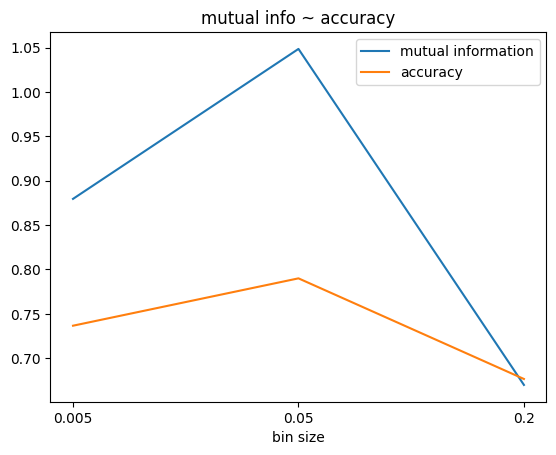

In [69]:
plt.plot([mutual_info_0005, mutual_info_005, mutual_info_02])
plt.plot([accuracy_0005, accuracy_005, accuracy_02])
plt.legend(['mutual information', 'accuracy'])

plt.xticks([0, 1, 2], ['0.005', '0.05', '0.2'])
plt.xlabel('bin size')
plt.title('mutual info ~ accuracy')
plt.savefig('figure.png')

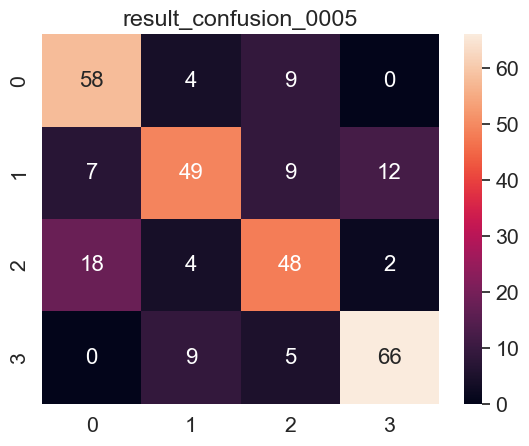

array([[58,  4,  9,  0],
       [ 7, 49,  9, 12],
       [18,  4, 48,  2],
       [ 0,  9,  5, 66]])

In [89]:
array = result_confusion_0005
df_cm = pd.DataFrame(array)
sn.set(font_scale=1.4) # for label size
sns_plot = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('result_confusion_0005')
plt.show()
sns_plot.figure.savefig("result_confusion_0005.png")

result_confusion_0005

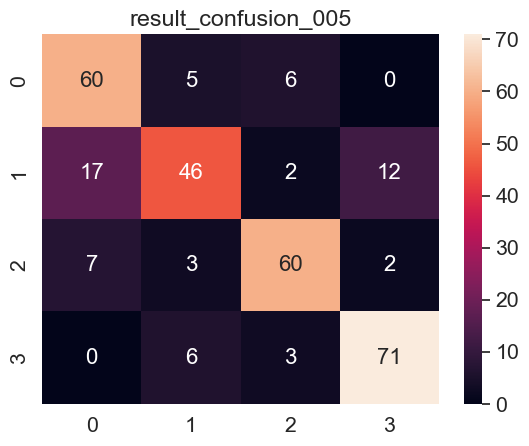

array([[60,  5,  6,  0],
       [17, 46,  2, 12],
       [ 7,  3, 60,  2],
       [ 0,  6,  3, 71]])

In [91]:
array = result_confusion_005
df_cm = pd.DataFrame(array)
sn.set(font_scale=1.4) # for label size
sns_plot = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('result_confusion_005')
plt.show()
sns_plot.figure.savefig("result_confusion_005.png")

result_confusion_005